**This notebook is an exercise in the [Introduction to Machine Learning](https://www.kaggle.com/learn/intro-to-machine-learning) course.  You can reference the tutorial at [this link](https://www.kaggle.com/alexisbcook/machine-learning-competitions).**

---


# Introduction

In this exercise, you will create and submit predictions for a Kaggle competition. You can then improve your model (e.g. by adding features) to improve and see how you stack up to others taking this course.

The steps in this notebook are:
1. Build a Random Forest model with all of your data (**X** and **y**).
2. Read in the "test" data, which doesn't include values for the target.  Predict home values in the test data with your Random Forest model.
3. Submit those predictions to the competition and see your score.
4. Optionally, come back to see if you can improve your model by adding features or changing your model. Then you can resubmit to see how that stacks up on the competition leaderboard.

## Recap
Here's the code you've written so far. Start by running it again.

In [1]:
# Code you have previously used to load data
import pandas as pd
import numpy as np
from matplotlib import pyplot
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import OrdinalEncoder
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from datetime import datetime
import warnings

# plot feature importance using built-in function
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance

# Set up code checking
import os
if not os.path.exists("../input/train.csv"):
    os.symlink("../input/home-data-for-ml-course/train.csv", "../input/train.csv")  
    os.symlink("../input/home-data-for-ml-course/test.csv", "../input/test.csv") 
from learntools.core import binder
binder.bind(globals())
from learntools.machine_learning.ex7 import *

In [2]:
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [3]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [4]:
# Turn off warning messages
warnings.filterwarnings('ignore') 

# Path of the file to read. We changed the directory structure to simplify submitting to a competition
iowa_file_path = '../input/train.csv'
home_data = pd.read_csv(iowa_file_path)

# Fill NaN values with the previous value in the column
home_data.fillna(method = 'ffill', inplace = True)
home_data.fillna(method = 'bfill', inplace = True)

# Create target object and call it y
y = home_data.SalePrice

# Convert categorical data into numeric labels
num_features = list(home_data.select_dtypes(include=[np.number]).columns)
cat_features = 'MSZoning Street Alley LotShape LandContour Utilities LotConfig LandSlope Neighborhood \
        Condition1 Condition2 BldgType HouseStyle RoofStyle RoofMatl Exterior1st Exterior2nd \
        MasVnrType ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1 \
        BsmtFinType2 Heating HeatingQC CentralAir Electrical KitchenQual Functional FireplaceQu \
        GarageType GarageFinish GarageQual GarageCond PavedDrive PoolQC Fence MiscFeature SaleType \
        SaleCondition'.split()

ord_enc = OrdinalEncoder()
cat_code_features = []
for f in cat_features:
    cat_code_features.append(f + '_code')
    home_data[f + '_code'] = ord_enc.fit_transform(home_data[[f]])

# Calculate correlation coefficients between SalePrice and other columns
features = num_features + cat_code_features
# corrs = {}
# for f in features:
#     corrs[f] = np.round(home_data['SalePrice'].corr(home_data[f], method = 'pearson'),2)
# corrs_sorted = dict(sorted(corrs.items(), key=lambda item: np.abs(item[1]), reverse = True))
# print("\n".join("{}\t{}".format(k, v) for k, v in corrs_sorted.items()))

# # Selecting only features with large magnitude correlation coefficients
# features = list(dict(filter(lambda elem: abs(elem[1]) > 0.1, corrs_sorted.items())).keys())
features.remove('SalePrice')
features.remove('Id')
# print(features)

# Create X
X = home_data[features]

# Split into validation and training data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

In [5]:
# Specify Model
iowa_model = DecisionTreeRegressor(random_state=1)
# Fit Model
iowa_model.fit(train_X, train_y)

# Make validation predictions and calculate mean absolute error
val_predictions = iowa_model.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)
print("Validation MAE when not specifying max_leaf_nodes: {:,.0f}".format(val_mae))

# Using best value for max_leaf_nodes
iowa_model = DecisionTreeRegressor(max_leaf_nodes=100, random_state=1)
iowa_model.fit(train_X, train_y)
val_predictions = iowa_model.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)
print("Validation MAE for best value of max_leaf_nodes: {:,.0f}".format(val_mae))

# Define the model. Set random_state to 1
rf_model = RandomForestRegressor(random_state=1)
rf_model.fit(train_X, train_y)
rf_val_predictions = rf_model.predict(val_X)
rf_val_mae = mean_absolute_error(rf_val_predictions, val_y)
print("Validation MAE for Random Forest Model: {:,.0f}".format(rf_val_mae))

Validation MAE when not specifying max_leaf_nodes: 26,833
Validation MAE for best value of max_leaf_nodes: 24,563
Validation MAE for Random Forest Model: 16,542


Validation MAE for Extreme Gradient Boost Model: 14,628


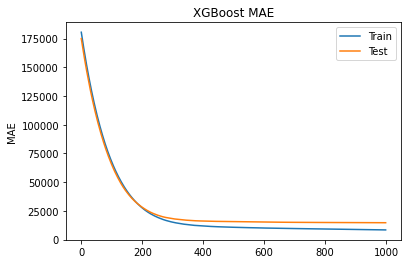

In [6]:
# Extreme Gradient Boost model
xgb_model = XGBRegressor(n_estimators=1000,max_depth=4,min_child_weight=5,gamma=10,learning_rate=0.01,eval_metric='mae',
                        subsample=0.8)
# xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators = 32, max_depth = 4)
with HiddenPrints():
    xgb_model.fit(train_X, train_y,eval_set = [(train_X,train_y), (val_X, val_y)])
xgb_val_predictions = xgb_model.predict(val_X)
xgb_val_mae = mean_absolute_error(xgb_val_predictions, val_y)
print("Validation MAE for Extreme Gradient Boost Model: {:,.0f}".format(xgb_val_mae))

# # param_grid = dict(n_estimators=[8,16])#, max_depth=[3,4,5,6,8])#, learning_rate = [.02,.05,.1,.2,.3]) 
# # #                   gamma = [0,0.1,0.2,0.3], min_child_weight = [1,3,5])
# param_grid = dict(subsample=[0.4,0.6,0.8,1])
# # grid = GridSearchCV(estimator=xgb_model, param_grid=param_grid, n_jobs=-1, cv=3, scoring = 'neg_mean_absolute_error')
# grid = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, n_jobs=-1, cv=3, scoring = 'neg_mean_absolute_error')

# start_time = datetime.now()
# grid_result = grid.fit(train_X, train_y)
# end_time = datetime.now()
# print('Duration: {}'.format(end_time - start_time))
# print(grid_result)
# print(grid.best_params_)

# Plotting error vs. epoch number
results = xgb_model.evals_result()

epochs = len(results['validation_0']['mae'])
x_axis = range(0, epochs)

fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['mae'], label='Train')
ax.plot(x_axis, results['validation_1']['mae'], label='Test')
ax.legend()
pyplot.ylabel('MAE')
pyplot.title('XGBoost MAE')
pyplot.show()

In [7]:
home_data.head()
home_data.describe(include = 'all')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,GarageType_code,GarageFinish_code,GarageQual_code,GarageCond_code,PavedDrive_code,PoolQC_code,Fence_code,MiscFeature_code,SaleType_code,SaleCondition_code
count,1460.000000,1460.000000,1460,1460.000000,1460.000000,1460,1460,1460,1460,1460,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
unique,NaN,NaN,5,NaN,NaN,2,2,4,4,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,RL,NaN,NaN,Pave,Grvl,Reg,Lvl,AllPub,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,1151,NaN,NaN,1454,790,925,1311,1459,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,730.500000,56.897260,NaN,70.104795,10516.828082,NaN,NaN,NaN,NaN,NaN,...,2.292466,1.184247,3.858904,3.900685,1.856164,0.459589,1.478767,1.938356,7.513014,3.770548
std,421.610009,42.300571,NaN,23.846996,9981.264932,NaN,NaN,NaN,NaN,NaN,...,1.787574,0.810079,0.621157,0.518737,0.496592,0.660558,0.825544,0.498422,1.552100,1.100854
min,1.000000,20.000000,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,365.750000,20.000000,NaN,59.000000,7553.500000,NaN,NaN,NaN,NaN,NaN,...,1.000000,0.000000,4.000000,4.000000,2.000000,0.000000,1.000000,2.000000,8.000000,4.000000
50%,730.500000,50.000000,NaN,70.000000,9478.500000,NaN,NaN,NaN,NaN,NaN,...,1.000000,1.000000,4.000000,4.000000,2.000000,0.000000,2.000000,2.000000,8.000000,4.000000
75%,1095.250000,70.000000,NaN,80.000000,11601.500000,NaN,NaN,NaN,NaN,NaN,...,5.000000,2.000000,4.000000,4.000000,2.000000,1.000000,2.000000,2.000000,8.000000,4.000000


# Creating a Model For the Competition

Build a Random Forest model and train it on all of **X** and **y**.

In [8]:
# To improve accuracy, create a new Extreme Gradient Boost model which you will train on all training data
xgb_model_on_full_data = XGBRegressor(n_estimators=1000,max_depth=4,min_child_weight=5,gamma=10,learning_rate=0.01,eval_metric='mae',
                        subsample=0.8)
# fit xgb_model_on_full_data on all data from the training data
xgb_model_on_full_data.fit(X,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='mae',
             gamma=10, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=4, min_child_weight=5, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=4,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.8, tree_method='exact',
             validate_parameters=1, verbosity=None)

# Make Predictions
Read the file of "test" data. And apply your model to make predictions

In [9]:
# path to file you will use for predictions
test_data_path = '../input/test.csv'

# read test data file using pandas
test_data = pd.read_csv(test_data_path)

# Fill NaN values with 0
test_data.fillna(method = 'ffill', inplace = True)
test_data.fillna(method = 'bfill', inplace = True)

# Convert categorical data into numeric labels
num_features = list(test_data.select_dtypes(include=[np.number]).columns)
cat_features = 'MSZoning Street Alley LotShape LandContour Utilities LotConfig LandSlope Neighborhood \
        Condition1 Condition2 BldgType HouseStyle RoofStyle RoofMatl Exterior1st Exterior2nd \
        MasVnrType ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1 \
        BsmtFinType2 Heating HeatingQC CentralAir Electrical KitchenQual Functional FireplaceQu \
        GarageType GarageFinish GarageQual GarageCond PavedDrive PoolQC Fence MiscFeature SaleType \
        SaleCondition'.split()

ord_enc = OrdinalEncoder()
cat_code_features = []
for f in cat_features:
    cat_code_features.append(f + '_code')
    test_data[f + '_code'] = ord_enc.fit_transform(test_data[[f]])

# Create X
features = num_features + cat_code_features
features.remove('Id')
test_X = test_data[features]

# make predictions which we will submit. 
test_preds = xgb_model_on_full_data.predict(test_X)

# The lines below shows how to save predictions in format used for competition scoring
# Just uncomment them.

output = pd.DataFrame({'Id': test_data.Id,
                       'SalePrice': test_preds})
output.to_csv('submission_v6.csv', index=False)

Before submitting, run a check to make sure your `test_preds` have the right format.

In [10]:
# Check your answer
step_1.check()
# step_1.solution()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

# Test Your Work

To test your results, you'll need to join the competition (if you haven't already).  So open a new window by clicking on [this link](https://www.kaggle.com/c/home-data-for-ml-course).  Then click on the **Join Competition** button.

![join competition image](https://i.imgur.com/axBzctl.png)

Next, follow the instructions below:
1. Begin by clicking on the blue **Save Version** button in the top right corner of the window.  This will generate a pop-up window.  
2. Ensure that the **Save and Run All** option is selected, and then click on the blue **Save** button.
3. This generates a window in the bottom left corner of the notebook.  After it has finished running, click on the number to the right of the **Save Version** button.  This pulls up a list of versions on the right of the screen.  Click on the ellipsis **(...)** to the right of the most recent version, and select **Open in Viewer**.  This brings you into view mode of the same page. You will need to scroll down to get back to these instructions.
4. Click on the **Output** tab on the right of the screen.  Then, click on the blue **Submit** button to submit your results to the leaderboard.

You have now successfully submitted to the competition!

If you want to keep working to improve your performance, select the blue **Edit** button in the top right of the screen. Then you can change your code and repeat the process. There's a lot of room to improve, and you will climb up the leaderboard as you work.


# Continuing Your Progress
There are many ways to improve your model, and **experimenting is a great way to learn at this point.**

The best way to improve your model is to add features.  Look at the list of columns and think about what might affect home prices.  Some features will cause errors because of issues like missing values or non-numeric data types. 

The **[Intermediate Machine Learning](https://www.kaggle.com/learn/intermediate-machine-learning)** course will teach you how to handle these types of features. You will also learn to use **xgboost**, a technique giving even better accuracy than Random Forest.


# Other Courses
The **[Pandas](https://kaggle.com/Learn/Pandas)** course will give you the data manipulation skills to quickly go from conceptual idea to implementation in your data science projects. 

You are also ready for the **[Deep Learning](https://kaggle.com/Learn/Deep-Learning)** course, where you will build models with better-than-human level performance at computer vision tasks.

---




*Have questions or comments? Visit the [Learn Discussion forum](https://www.kaggle.com/learn-forum/161285) to chat with other Learners.*